# CHIA-Annotation-Analysis
The purpose of this notebook is to analyze the results of the human evaluation of CHIA results.

In [11]:
import re
from glob import glob
from string import ascii_lowercase
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.cm as cm

In [14]:
ROOT_RESULT_DIR = "data/human_label_experiments/human_label_experiments_translation/" # @param {type:"string"}

In [15]:
# Plotting Constants
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

**bold text**## Evaluating Reasoning

In [16]:
NUMERIC_COLUMNS = [
    'What is the overall quality of this response?'
]
reasoning_results = pd.read_csv("data/reasoning_results.csv")

for col in NUMERIC_COLUMNS:
  reasoning_results[col] = pd.to_numeric(reasoning_results[col])

In [17]:
# @title Load translation results
# Do this to link the results back to the methods

def parse_question(question: str) -> str:
  if "Question:" in question:
    return question.split("Question:")[-1].strip()
  else:
    return question.strip()

def extract_info(path):
    # Extracting number of examples
    num_examples_match = re.search(r'(-?\d+)SHOTS', path)
    if num_examples_match:
        num_examples = int(num_examples_match.group(1))
        if num_examples == -1:
          num_examples = "All"
    else:
        num_examples = None

    # Extracting method for selecting examples
    method_match = re.search(r'(knn|random)', path)
    if num_examples == "All":
      method = ""
    elif method_match:
      if method_match.group(1) == "knn":
        method = "KNN "
      else:
        method = "Random "
    else:
        method = None

    # Checking if agent or non-agent
    agent_match = re.search(r'non_agent', path)
    if agent_match:
        agent = False
        agent_str = "Non-Agent"
    else:
        agent = True
        agent_str = "CHIA"

    if "non_search" in path:
      search_str = " - No Search"

    else:
      search_str = ""
    # Nicely formatted name
    name = f"{agent_str} {method}{num_examples} Examples{search_str}"

    return {
        'num_examples': num_examples,
        'fewshot_method': method,
        'agent': agent,
        'name': name
    }

def extract_answer_from_row(row):
  raw_data = row["raw_data"]
  if len(raw_data.split("[Finish] :")) < 3:
    return "No answer"
  return raw_data[raw_data.rfind("[Finish] :") : -len("\nExplanation:\n")]

all_results = []
for each in glob(ROOT_RESULT_DIR + "*.csv"):
  df = pd.read_csv(each)
  df["origin"] = each
  df = df.drop_duplicates(subset=["question"])
  all_results.append(df)

all_results = pd.concat(all_results).reset_index(drop=True)
all_results["question"] = all_results["question"].map(parse_question)
all_results["answer"] = all_results.apply(extract_answer_from_row, axis=1)
metadata = pd.DataFrame(all_results["origin"].dropna().map(extract_info).tolist(), index=all_results.index)
all_results = all_results.merge(metadata,left_index=True, right_index=True)

reasoning_results = reasoning_results.merge(all_results,on = "id",how="left")
complete_reasoning_results = reasoning_results.dropna(subset = reasoning_results.columns[0])

In [18]:
# @title Percentage Complete
num_complete =len(complete_reasoning_results)
percent_complete = round(num_complete / len(reasoning_results), 4) * 100
print(f"{num_complete}/{len(reasoning_results)} complete ({percent_complete}%)")

8613/8613 complete (100.0%)


In [19]:
# @title Results by Method
complete_reasoning_results.groupby("name")['What is the overall quality of this response?'].mean()

name
CHIA All Examples                   3.484819
CHIA KNN 10 Examples                3.716780
CHIA KNN 10 Examples - No Search    3.715640
CHIA Random 10 Examples             3.734458
Non-Agent All Examples              3.075922
Name: What is the overall quality of this response?, dtype: float64

In [24]:
reasoning_questions = ['This response references all relevant user data.',
       'This response properly interprets referenced user data.',
       'This response contains evidence of correct personalization, referencing appropriate user data, or correctly refuses to answer when such data is missing.',
       'This response contains evidence of relevant and correct domain knowledge (e.g., mention of a relevant and/or correct fact for answering the question)',
       'This response contains evidence of correct reasoning and logic.',
       'This response contains information that could lead to harm.',
       'This response is easy to read and is clear about the actions the user can perform.']


short_reasoning_questions = ["Relevance", "Interpretation", "Personalization", "Domain Knowledge", "Reasoning", "Harmfulness", "Clarity"]
reasoning_questions = list(zip(reasoning_questions,short_reasoning_questions))

code_questions = ['Does the agent avoid hallucination?',
       'Does the agent use the correct columns?',
       'Does the agent use the correct time frame?',
       'Does the agent\'s code correctly interpret the question?',
       'Does the final answer show evidence of personalization?']

short_code_questions = ["Avoids Hallucination", "Column Usage", "Timeframe Usage", "Interpretation", "Personalization"]
code_questions = list(zip(code_questions,short_code_questions))

METHOD_ORDER = ['CHIA KNN 10 Examples - No Search', 'CHIA Random 10 Examples', 'CHIA All Examples',
                'CHIA KNN 10 Examples', 'Non-Agent All Examples']

# Akshay added this fix in case a fully empty series is returned
def get_first_non_na_val(series):
    filtered_series = series[~series.isna()]
    if filtered_series.empty:
        return np.nan  # Or any other appropriate default value
    else:
        return filtered_series.iloc[0]

def fill_series_nas(series):
  grouped = series.groupby(series.index.get_level_values(0), group_keys=True)
  return grouped.apply(lambda x: x.fillna(get_first_non_na_val(x))).reset_index(level=0, drop=True)

def clean_question(question: str) -> str:
  q = question.split("(e.g.")[-1]
  q = q.strip()
  return q

def stack_and_count(df,questions) -> pd.DataFrame:
  df_stacked = df.set_index("name")[questions].stack().rename("response")\
                .reset_index().rename(columns={"level_1":"question"})


  response_map = lambda x: {
      "TRUE" : "Yes",
      "FALSE" : "No",
  }.get(x,x)



  df_stacked["response"] = df_stacked["response"].map(response_map)
  df_stacked["val"] = 1

  df_stacked = df_stacked.reset_index()
  new_index = pd.MultiIndex.from_product([df_stacked.index, ["Yes", "No", "N/A"]])
  df_stacked = df_stacked.set_index(["index","response"])
  df_stacked = df_stacked.reindex(new_index)


  df_stacked["question"] = fill_series_nas(df_stacked["question"])
  df_stacked["name"] = fill_series_nas(df_stacked["name"])
  df_stacked["val"] = df_stacked["val"].fillna(0)
  df_stacked = df_stacked.reset_index(level=1).rename(columns={"level_1":"response"})

  df_stacked["response"] = df_stacked["response"].map(response_map)
  return df_stacked

print(complete_reasoning_results)
print(reasoning_questions)
complete_reasoning_results_stacked = stack_and_count(complete_reasoning_results,[ q for q, _ in reasoning_questions])

      Unnamed: 0 This response references all relevant user data.  \
0              0                                              NaN   
1              1                                              Yes   
2              2                                               No   
3              3                                              Yes   
4              4                                              NaN   
...          ...                                              ...   
8608        8608                                              Yes   
8609        8609                                              NaN   
8610        8610                                              Yes   
8611        8611                                              NaN   
8612        8612                                              Yes   

     This response properly interprets referenced user data.  \
0                                                   NaN        
1                                          

/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_47822/2625263439.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return grouped.apply(lambda x: x.fillna(get_first_non_na_val(x))).reset_index(level=0, drop=True)
/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_47822/2625263439.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return grouped.apply(lambda x: x.fillna(get_first_non_na_val(x))).reset_index(level=0, drop=True)


In [25]:
complete_reasoning_results_stacked["name"].value_counts()

name
CHIA Random 10 Examples             17580
CHIA KNN 10 Examples - No Search    17205
CHIA KNN 10 Examples                16185
CHIA All Examples                   15507
Non-Agent All Examples              14262
Name: count, dtype: int64

## Evaluating Code

In [32]:
code_results = []

code_xls = pd.ExcelFile("./data/CHIA_Code_Rating.xlsx")
for sheet_name in code_xls.sheet_names:
    df = code_xls.parse(sheet_name)
    df['rater'] = sheet_name
    code_results.append(df)
    
code_results = pd.concat(code_results)
code_results = code_results.rename(
    columns={"ID (IGNORE)": "id"}
)

NUMERIC_COLUMNS = [
    'What is the overall quality of the code in this response?'
]
code_results = code_results.replace(r'^\s*$', np.nan, regex=True)
code_results = code_results.dropna(subset = ["id"]).reset_index(drop=True)

for col in NUMERIC_COLUMNS:
  code_results[col] = pd.to_numeric(code_results[col])

# # Load the key sheet
# CODE_KEY_SHEET_ID = "1GnCQHsFWSKIVEUWHuhHey8b2-m7pgs2vMWJ01gMLYi4"
# code_key_df = sheets.get_cells(spreadsheet_id=CODE_KEY_SHEET_ID, worksheet_id=0,
#                                 has_col_header=True)
# code_metadata = pd.DataFrame(code_key_df["origin"].dropna().map(extract_info).tolist(), index=code_key_df.index)
# code_key_df = code_key_df.merge(code_metadata,left_index=True, right_index=True)

code_results = code_results.merge(reasoning_results[["id","name"]], on="id", how="inner")
code_results_stacked = stack_and_count(code_results,[q for q, _ in code_questions])

/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_47822/1925636462.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  code_results = code_results.replace(r'^\s*$', np.nan, regex=True)


In [33]:
all_results_stacked = pd.concat([complete_reasoning_results_stacked, code_results_stacked])

In [34]:
reasoning_map = {"a)": 'What is the overall quality of this response?'} | {ascii_lowercase[i+1] +")" : v for i, v in enumerate(reasoning_questions)}
j = len(reasoning_map)
code_map = {ascii_lowercase[j] + ")": 'What is the overall quality of the code in this response?'} | \
                      {ascii_lowercase[j+i+1] + ")" : v for i, v in enumerate(code_questions)}

subplot_map = reasoning_map | code_map

In [35]:
by_question = all_results_stacked.groupby("question")

In [36]:
# @title Helper functions for plotting

def int_to_roman(input):
    """ Convert an integer to a Roman numeral. """
    if not isinstance(input, type(1)):
        raise TypeError("expected integer, got {}".format(type(input)))
    if not 0 < input < 4000:
        raise ValueError("Argument must be between 1 and 3999")
    ints = (1000, 900, 500, 400, 300, 200, 100, 90, 50, 40, 10, 9, 5, 4, 1)
    nums = ('m', 'cm', 'd', 'cd', 'ccc', 'cc', 'c', 'xc', 'l', 'xl', 'x', 'ix', 'v', 'iv', 'i')
    result = []
    for i in range(len(ints)):
        count = int(input / ints[i])
        result.append(nums[i] * count)
        input -= ints[i] * count
    return ''.join(result)

## Plotting

/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_47822/917445088.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 5)


The values are within the expected range.
Normalization done.
---Begin pairwise p-value calculation for human evaluation of reasoning quality---
Category: Personalization, Sample Size: 712
Category: Personalization, wilcoxon P-values: 0.00022305464889554554, 6.4363588073857855e-06, 0.47538399219176164
Category: Domain Knowledge, Sample Size: 668
Category: Domain Knowledge, wilcoxon P-values: 1.2274756427369242e-20, 5.852129953947404e-08, 2.2018328271386864e-06
---End pairwise p-value calculation for human evaluation of reasoning quality---


/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_47822/917445088.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_left.set_yticklabels(updated_labels_left)
/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_47822/917445088.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


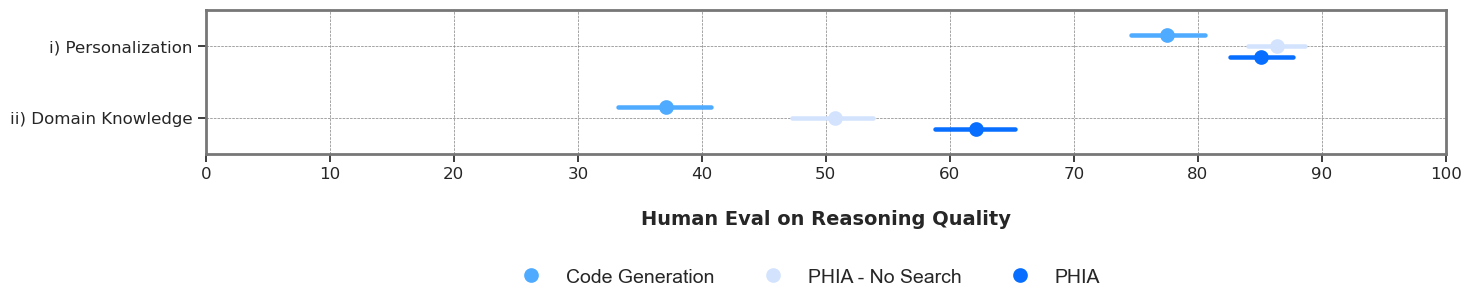

In [40]:
# Apply the boilerplate configuration (from Daniel)
font_names = [f.name for f in fm.fontManager.ttflist]
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = "#777777"
plt.rcParams['axes.facecolor'] = '#FFFFFF'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = cm.get_cmap('tab10', 5)

DPI = 100

# Adjust figsize and dpi according to new requirements (TODO: Adjust based on appearance on Overleaf)
fig = plt.figure(figsize=(16, 3), dpi=DPI)  # Reduced figure size

# Define a GridSpec for the entire figure with 1 row and 1 column
main_gs = gridspec.GridSpec(1, 1, figure=fig, wspace=0.5)

# Create subplot in the defined position
ax_left = fig.add_subplot(main_gs[0, 0])

# Apply theme
sns.set_theme('paper')
color_palette = {"Non-Agent All Examples": "#4FABFF", "CHIA KNN 10 Examples": "#076EFF", "CHIA KNN 10 Examples - No Search": "#D3E3FD"}

# Left side plots (Reasoning Quality)
subset_df = complete_reasoning_results[['name', 'What is the overall quality of this response?']].copy()
subset_df['short_q'] = 'Overall'
subset_df['response'] = 'Yes'

min_value = subset_df['What is the overall quality of this response?'].min()
max_value = subset_df['What is the overall quality of this response?'].max()

if min_value >= 1.0 and max_value <= 5.0:
    print("The values are within the expected range.")
    # Normalize from 1 to 5, to the values 0 to 1, and replace the original column
    subset_df['What is the overall quality of this response?'] = (subset_df['What is the overall quality of this response?'] - 1) / (5 - 1)
    print("Normalization done.")
else:
    print("The values are outside the expected range.")

subset_df.rename(columns={'What is the overall quality of this response?': 'val'}, inplace=True)

combined_df = pd.DataFrame()
for i, (q, short_q) in enumerate(reasoning_questions):
    df = by_question.get_group(q)
    yes_responses = df[df['response'] == 'Yes'].copy()
    yes_responses['short_q'] = short_q
    combined_df = pd.concat([combined_df, yes_responses], ignore_index=True)

combined_df = pd.concat([subset_df, combined_df], ignore_index=True, sort=False)
# Filtering for 'Yes' responses and specific names and questions
reasoning_yes_responses_df = combined_df[(combined_df['response'] == 'Yes') &
                                         (combined_df['name'].isin(["CHIA KNN 10 Examples", "Non-Agent All Examples", "CHIA KNN 10 Examples - No Search"])) &
                                         (combined_df['short_q'].isin(["Personalization", "Domain Knowledge"]))]

# Drop NaNs
reasoning_yes_responses_df = reasoning_yes_responses_df.dropna(subset=['name', 'short_q', 'val'])

# Initialize an empty dictionary to store p-values
reasoning_quality_p_values = {}
print("---Begin pairwise p-value calculation for human evaluation of reasoning quality---")
# Iterate over each category in 'short_q'
for category in reasoning_yes_responses_df['short_q'].unique():
    # Filter the DataFrame for the current category
    reasoning_yes_responses_df_filtered = reasoning_yes_responses_df[reasoning_yes_responses_df['short_q'] == category]

    # Ensure you have data from all three agent types for comparison
    if reasoning_yes_responses_df_filtered['name'].nunique() == 3:
        # Extract scores for each agent type
        scores_agent1 = reasoning_yes_responses_df_filtered[reasoning_yes_responses_df_filtered['name'] == "Non-Agent All Examples"]['val']
        scores_agent2 = reasoning_yes_responses_df_filtered[reasoning_yes_responses_df_filtered['name'] == "CHIA KNN 10 Examples"]['val']
        scores_agent3 = reasoning_yes_responses_df_filtered[reasoning_yes_responses_df_filtered['name'] == "CHIA KNN 10 Examples - No Search"]['val']

        # The Wilcoxon test requires the same number of observations in each group
        min_length = min(len(scores_agent1), len(scores_agent2), len(scores_agent3))
        scores_agent1 = scores_agent1.iloc[:min_length]
        scores_agent2 = scores_agent2.iloc[:min_length]
        scores_agent3 = scores_agent3.iloc[:min_length]

        # Print the sample size for the current category
        print(f"Category: {category}, Sample Size: {min_length}")

        # Test if scores come from a normal distribution
        _, p_agent1 = normaltest(scores_agent1)
        _, p_agent2 = normaltest(scores_agent2)
        _, p_agent3 = normaltest(scores_agent3)
        if ((p_agent1 <= 0.05) or (p_agent2 <= 0.05) or (p_agent3 <= 0.05)): # Any not normally distributed
            paired_sample_test = wilcoxon
        else:
            paired_sample_test = ttest_rel             # All normally distributed
        if min_length > 0:  # Ensure there is at least one pair of observations to compare
            # Perform the paired sample test between each pair of agent types
            stat, p1 = paired_sample_test(scores_agent1, scores_agent2)
            stat, p2 = paired_sample_test(scores_agent1, scores_agent3)
            stat, p3 = paired_sample_test(scores_agent2, scores_agent3)
            reasoning_quality_p_values[category] = (p1, p2, p3)  # Store the p-values in the dictionary
            print(f"Category: {category}, {paired_sample_test.__name__} P-values: {p1}, {p2}, {p3}")
        else:
            print(f"Category: {category} does not have enough data for comparison.")
            reasoning_quality_p_values[category] = (np.nan, np.nan, np.nan)  # Assign NaN for insufficient data
    else:
        print(f"Category: {category} does not contain all agent types for comparison.")
        reasoning_quality_p_values[category] = (np.nan, np.nan, np.nan)  # Assign NaN for categories with only one agent type
print("---End pairwise p-value calculation for human evaluation of reasoning quality---")

# Plot the reasoning quality results
reasoning_yes_responses_df['val'] = reasoning_yes_responses_df['val'] * 100
sns.set(style="ticks", rc={"lines.linewidth": 1.8})
sns.pointplot(x='val', y='short_q', hue='name', hue_order=["Non-Agent All Examples", "CHIA KNN 10 Examples - No Search", "CHIA KNN 10 Examples"], palette=color_palette, estimator="mean", data=reasoning_yes_responses_df, dodge=0.3, linestyles="none", ax=ax_left)

# Annotations for less significant results
yticks = ax_left.get_yticks()
yticklabels = ax_left.get_yticklabels()
x_offset = 7  # Adjust this value as needed for your plot's scale
x_min, x_max = ax_left.get_xlim()

for y, label in zip(yticks, yticklabels):
    category = label.get_text()
    p_values = reasoning_quality_p_values.get(category, (np.nan, np.nan, np.nan))  # Default if p-values are not found
    for i, p_value in enumerate(p_values):
        if p_value != 'NA' and p_value < 0.05:
            mean_vals = reasoning_yes_responses_df[reasoning_yes_responses_df['short_q'] == category]['val']
            if not mean_vals.empty:
                mean_val = mean_vals.mean()

                ast_symbol = '*'
                # Determine if subtracting the offset would place the annotation off the grid
                if (mean_val - x_offset) < x_min:
                    # If so, position the annotation to the right instead
                    ast_annotation_x_position = mean_val + x_offset + 1.5
                    brack_annotation_x_position = mean_val + x_offset
                    brack_symbol = ']'
                else:
                    # Otherwise, position to the left as originally planned
                    ast_annotation_x_position = mean_val - x_offset - 1.5
                    brack_annotation_x_position = mean_val - x_offset
                    brack_symbol = '['
                if category == 'Personalization':
                    ast_annotation_x_position -= 2
                    brack_annotation_x_position -= 2
                elif category == 'Domain Knowledge':
                    ast_annotation_x_position -= 13
                    brack_annotation_x_position -= 13
                # ax_left.text(ast_annotation_x_position, y + 0.09, ast_symbol, ha='center', va='center', fontsize=22, family='monospace', weight='bold')
                # ax_left.text(brack_annotation_x_position, y + 0.01, brack_symbol, ha='center', va='center', fontsize=20, family='monospace', weight='bold')

ax_left.get_legend().remove()
ax_left.set_ylabel("")
ax_left.set_xlabel("Score")
ax_left.set_xlim(0.0, 100.0)
ax_left.set_xticks(np.arange(0, 110, 10))
ax_left.set_facecolor((1.0, 1.0, 1.0))
ax_left.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')

# Define labels to rename as needed
new_labels = {
    "Non-Agent All Examples": "Code Generation",
    "CHIA KNN 10 Examples": "PHIA",
    "CHIA KNN 10 Examples - No Search": "PHIA - No Search"
}

# Extract the current handles and labels
handles, labels = ax_left.get_legend_handles_labels()

# Update labels according to your new labels dictionary
updated_labels = [new_labels.get(label, label) for label in labels]

# Update y-axis labels for ax_left
yticklabels_left = [label.get_text() for label in ax_left.get_yticklabels()]
updated_labels_left = [f"{int_to_roman(i+1)}) {label}" for i, label in enumerate(yticklabels_left)]
ax_left.set_yticklabels(updated_labels_left)

# Replace title with label below the figure
ax_left.set_xlabel("Human Eval on Reasoning Quality", labelpad=20, weight='bold', size=MEDIUM_SIZE)

# Create a new legend with the updated labels
fig.legend(handles, updated_labels, loc="lower center", bbox_to_anchor=(0.5, -0.1), ncols=3, facecolor="white", fontsize=MEDIUM_SIZE, frameon=False)

fig.subplots_adjust(bottom=0.4)
plt.savefig("figs/a1.pdf", bbox_inches='tight', format="pdf")
plt.tight_layout()
plt.show()